<a href="https://colab.research.google.com/github/lis-r-barreto/Big-Data-com-PySpark/blob/master/Big_Data_com_PySpark_no_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisando os Dados do MovieLens 🎬**
## **Contexto**

<center>
<img src="https://s3-us-west-2.amazonaws.com/flx-editorial-wordpress/wp-content/uploads/2018/03/13153742/RT_300EssentialMovies_700X250.jpg" alt="Posters de filmes" width="50%"/>
</center> 

O **MovieLens** é um sistema de recomendação e comunidade virtual baseado na Web que recomenda filmes para os usuários assistirem, com base em suas preferências de filme usando filtro colaborativo das classificações e críticas de filmes dos membros. 

#### **O objetivo dessa análise é explorar dois conjuntos de dados do MovieLens que contém informações sobre diversos filmes e a partir dessas informações extrair insights.**

## **Big Data com PySpark**

<center>
<img class="one" src="https://aprendizadodemaquina.com/media/filer_public_thumbnails/filer_public/3a/65/3a658469-383e-4c1d-b4fb-502229858579/pyspark.png__800x450_q85_crop_subsampling-2.png"  height="150"><br>
</center>

A biblioteca PySpark permite você criar seu servidor Apache Spark, trabalhar com grandes volumes de dados e até mesmo fazer streaming em tempo real.

## **1.0. Configurações 🛠️**

<center>
<img src="https://1.bp.blogspot.com/-SJ9kDlUd5qo/Xuo_0lQytwI/AAAAAAACK4M/J4miSQMT1OsJT5XMG9Au5DfiO_fd18kfgCLcBGAsYHQ/s1600/b1d5c4ae072a7173830c7c17690ed2c9.gif" alt="Cena do filmes Tempos Modernos com Charles Chaplin nas engrenagens" width="400"/>
</center>

In [138]:
# Instalando as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install koalas

A próxima etapa é configurar as variáveis de ambiente, pois isso habilita o ambiente do Colab a identificar corretamente onde as dependências estão rodando.

Para conseguir “manipular” o terminal e interagir como ele, você pode usar a biblioteca os.

In [139]:
# Configurando as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# Tornando o PySpark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

# Importando as bibliotecas default
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D

# Importando o Koalas
import databricks.koalas

# Importando o PySpark SQL
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

Com tudo pronto, vamos rodar uma sessão local para testar se a instalação funcionou corretamente.

In [140]:
# Iniciando uma sessão local e importando os dados
sc = SparkSession.builder.master('local[*]').getOrCreate()

## **2.0. Obtenção dos Dados**

Trabalharemos com um conjunto de dados real, a avaliação de diversos filmes por usuários da internet, do MovieLens. O site abriga variações destes dados, que podem ser baixados sob licença de uso. Existem versões de 20 milhões, 100 mil, 27 milhões de notas (ratings) para filmes, e por aí vai.

Nesta análise optaremos pelo arquivo contendo 100 mil. Cada versão disponibilizada pelo site é atualizada periodicamente, então, se baixarmos uma delas hoje, provavelmente dali um tempo o mesmo arquivo terá notas e filmes diferentes. Isso porque trata-se de uma amostra aleatória para análise. 

Começamos o nosso trabalho carregando o dataset:

In [141]:
# Download do http para arquivo local
!wget --quiet --show-progress https://raw.githubusercontent.com/lis-r-barreto/Big-Data-com-PySpark/master/data-movielens/movies.csv

!wget --quiet --show-progress https://raw.githubusercontent.com/lis-r-barreto/Big-Data-com-PySpark/master/data-movielens/ratings.csv

# Carregando dados
df_movies = sc.read.csv("./movies.csv", inferSchema=True, header=True)
df_ratings = sc.read.csv("./ratings.csv", inferSchema=True, header=True)

movies.csv.8        100%[===================>] 482.84K  --.-KB/s    in 0.009s  
ratings.csv.8       100%[===================>]   2.37M  --.-KB/s    in 0.05s   


### **Como as avaliações dos filmes estão organizadas?**

São muitas informações, portanto atribuiremos tudo isso a notas e, em vez de todas, utilizaremos o comando `show()` para ler apenas as 5 primeiras avaliações do dataset:

In [142]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [143]:
df_ratings.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



Para ler apenas as 5 últimas avaliações do dataset:

In [144]:
df_movies = df_movies.withColumn("index", F.monotonically_increasing_id())
df_movies.orderBy(F.desc("index")).drop("index").show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
| 193609|Andrew Dice Clay:...|              Comedy|
| 193587|Bungo Stray Dogs:...|    Action|Animation|
| 193585|        Flint (2017)|               Drama|
| 193583|No Game No Life: ...|Animation|Comedy|...|
| 193581|Black Butler: Boo...|Action|Animation|...|
+-------+--------------------+--------------------+
only showing top 5 rows



In [145]:
df_ratings = df_ratings.withColumn("index", F.monotonically_increasing_id())
df_ratings.orderBy(F.desc("index")).drop("index").show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|   610| 170875|   3.0|1493846415|
|   610| 168252|   5.0|1493846352|
|   610| 168250|   5.0|1494273047|
|   610| 168248|   5.0|1493850091|
|   610| 166534|   4.0|1493848402|
+------+-------+------+----------+
only showing top 5 rows



##**3.0. Manipulação dos Dados**

Para manipular os dados usaremos os métodos do PySpark, pois são mais rápidos que usar SQL além de ser mais intuitivo e ter menos retrabalho no código. 

In [146]:
inner_join_movies_ratings = df_movies.join(df_ratings, df_movies.movieId == df_ratings.movieId, 'inner')
inner_join_movies_ratings.show(5)

+-------+--------------------+--------------------+-----+------+-------+------+---------+-----+
|movieId|               title|              genres|index|userId|movieId|rating|timestamp|index|
+-------+--------------------+--------------------+-----+------+-------+------+---------+-----+
|      1|    Toy Story (1995)|Adventure|Animati...|    0|     1|      1|   4.0|964982703|    0|
|      3|Grumpier Old Men ...|      Comedy|Romance|    2|     1|      3|   4.0|964981247|    1|
|      6|         Heat (1995)|Action|Crime|Thri...|    5|     1|      6|   4.0|964982224|    2|
|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|   43|     1|     47|   5.0|964983815|    3|
|     50|Usual Suspects, T...|Crime|Mystery|Thr...|   46|     1|     50|   5.0|964982931|    4|
+-------+--------------------+--------------------+-----+------+-------+------+---------+-----+
only showing top 5 rows



In [147]:
# Vendo algumas informações sobre os tipos de dados de cada coluna
df_movies_ratings = inner_join_movies_ratings
df_movies_ratings.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- index: long (nullable = false)
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- index: long (nullable = false)



In [148]:
df_movies_ratings.summary().show()

+-------+----------------+--------------------+------------------+------------------+------------------+----------------+------------------+--------------------+---------------+
|summary|         movieId|               title|            genres|             index|            userId|         movieId|            rating|           timestamp|          index|
+-------+----------------+--------------------+------------------+------------------+------------------+----------------+------------------+--------------------+---------------+
|  count|          100836|              100836|            100836|            100836|            100836|          100836|            100836|              100836|         100836|
|   mean|19435.2957177992|                null|              null|3107.3762346780914|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|        50417.5|
| stddev|35530.9871987003|                null|              null|2633.5128007746953| 182.6184914635004|35530.

In [149]:
df_movies_ratings.drop("userId", "timestamp").show()

+-------+--------------------+--------------------+-----+-------+------+-----+
|movieId|               title|              genres|index|movieId|rating|index|
+-------+--------------------+--------------------+-----+-------+------+-----+
|      1|    Toy Story (1995)|Adventure|Animati...|    0|      1|   4.0|    0|
|      3|Grumpier Old Men ...|      Comedy|Romance|    2|      3|   4.0|    1|
|      6|         Heat (1995)|Action|Crime|Thri...|    5|      6|   4.0|    2|
|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|   43|     47|   5.0|    3|
|     50|Usual Suspects, T...|Crime|Mystery|Thr...|   46|     50|   5.0|    4|
|     70|From Dusk Till Da...|Action|Comedy|Hor...|   62|     70|   3.0|    5|
|    101|Bottle Rocket (1996)|Adventure|Comedy|...|   89|    101|   5.0|    6|
|    110|   Braveheart (1995)|    Action|Drama|War|   97|    110|   4.0|    7|
|    151|      Rob Roy (1995)|Action|Drama|Roma...|  124|    151|   5.0|    8|
|    157|Canadian Bacon (1...|          Comedy|War| 

In [150]:
df_movies_ratings.describe("genres").show()

+-------+------------------+
|summary|            genres|
+-------+------------------+
|  count|            100836|
|   mean|              null|
| stddev|              null|
|    min|(no genres listed)|
|    max|           Western|
+-------+------------------+



In [151]:
df_movies_ratings.describe("rating").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            100836|
|   mean| 3.501556983616962|
| stddev|1.0425292390606342|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



In [152]:
df_movies_ratings.select("rating").distinct().show()

+------+
|rating|
+------+
|   3.5|
|   4.5|
|   2.5|
|   1.0|
|   4.0|
|   0.5|
|   3.0|
|   2.0|
|   1.5|
|   5.0|
+------+



In [153]:
df_movies_ratings.select("title", "genres", "rating").filter(F.col("rating") >= 4.9).show(truncate=False)

+-----------------------------------------+--------------------------------------------+------+
|title                                    |genres                                      |rating|
+-----------------------------------------+--------------------------------------------+------+
|Seven (a.k.a. Se7en) (1995)              |Mystery|Thriller                            |5.0   |
|Usual Suspects, The (1995)               |Crime|Mystery|Thriller                      |5.0   |
|Bottle Rocket (1996)                     |Adventure|Comedy|Crime|Romance              |5.0   |
|Rob Roy (1995)                           |Action|Drama|Romance|War                    |5.0   |
|Canadian Bacon (1995)                    |Comedy|War                                  |5.0   |
|Desperado (1995)                         |Action|Romance|Western                      |5.0   |
|Billy Madison (1995)                     |Comedy                                      |5.0   |
|Dumb & Dumber (Dumb and Dumber) (1994) 

In [154]:
df_movies_ratings\
    .select("title","genres","rating")\
    .orderBy("rating").show(truncate=False)

+---------------------------------------------------+----------------------------------------+------+
|title                                              |genres                                  |rating|
+---------------------------------------------------+----------------------------------------+------+
|As Good as It Gets (1997)                          |Comedy|Drama|Romance                    |0.5   |
|Joy Ride (2001)                                    |Adventure|Thriller                      |0.5   |
|Pearl Harbor (2001)                                |Action|Drama|Romance|War                |0.5   |
|Requiem for a Dream (2000)                         |Drama                                   |0.5   |
|Star Wars: Episode II - Attack of the Clones (2002)|Action|Adventure|Sci-Fi|IMAX            |0.5   |
|Snow Dogs (2002)                                   |Adventure|Children|Comedy               |0.5   |
|Hulk (2003)                                        |Action|Adventure|Sci-Fi      

In [155]:
df_movies_ratings\
    .select("title","genres","rating", F.round(F.col("rating"), 1)\
    .alias("rating"))\
    .orderBy("rating", ascending=False).show(truncate=False)

+-------------------------------------------+--------------------------------------------+------+------+
|title                                      |genres                                      |rating|rating|
+-------------------------------------------+--------------------------------------------+------+------+
|Mr. Smith Goes to Washington (1939)        |Drama                                       |5.0   |5.0   |
|Blues Brothers, The (1980)                 |Action|Comedy|Musical                       |5.0   |5.0   |
|Winnie the Pooh and the Blustery Day (1968)|Animation|Children|Musical                  |5.0   |5.0   |
|Seven (a.k.a. Se7en) (1995)                |Mystery|Thriller                            |5.0   |5.0   |
|Three Caballeros, The (1945)               |Animation|Children|Musical                  |5.0   |5.0   |
|Bottle Rocket (1996)                       |Adventure|Comedy|Crime|Romance              |5.0   |5.0   |
|Sword in the Stone, The (1963)             |Animation|

In [156]:
df_movies_ratings\
    .select("title", "genres", "rating")\
    .filter(F.col("genres")\
    .like("%Fantasy%"))\
    .orderBy("rating", ascending=False)\
    .show(truncate=False)

+-------------------------------------------+---------------------------------------------------------+------+
|title                                      |genres                                                   |rating|
+-------------------------------------------+---------------------------------------------------------+------+
|Black Cauldron, The (1985)                 |Adventure|Animation|Children|Fantasy                     |5.0   |
|Fantasia (1940)                            |Animation|Children|Fantasy|Musical                       |5.0   |
|Conan the Barbarian (1982)                 |Action|Adventure|Fantasy                                 |5.0   |
|Pinocchio (1940)                           |Animation|Children|Fantasy|Musical                       |5.0   |
|Goonies, The (1985)                        |Action|Adventure|Children|Comedy|Fantasy                 |5.0   |
|Wizard of Oz, The (1939)                   |Adventure|Children|Fantasy|Musical                       |5.0   |
|

In [157]:
dimensions = ["title","genres","rating"]
metrics = ["rating"]
dim_df_movies_ratings = df_movies_ratings.groupBy(dimensions).count()
dim_df_movies_ratings.show()

+--------------------+--------------------+------+-----+
|               title|              genres|rating|count|
+--------------------+--------------------+------+-----+
|Starship Troopers...|       Action|Sci-Fi|   3.0|   17|
|    Hangar 18 (1980)|Action|Sci-Fi|Thr...|   5.0|    1|
| Multiplicity (1996)|              Comedy|   2.0|    5|
|Seven Samurai (Sh...|Action|Adventure|...|   5.0|   14|
|A.I. Artificial I...|Adventure|Drama|S...|   4.5|    3|
| Aviator, The (2004)|               Drama|   3.5|    6|
|Planes, Trains & ...|              Comedy|   3.5|    3|
|Flickering Lights...| Action|Comedy|Crime|   4.5|    1|
|    Hitchcock (2012)|               Drama|   3.5|    3|
|       Splash (1984)|Comedy|Fantasy|Ro...|   3.0|   14|
|Miss Congeniality...|        Comedy|Crime|   3.5|   13|
|The Man from U.N....|Action|Adventure|...|   3.5|    5|
|French Connection...|Action|Crime|Thri...|   4.5|    5|
|      Ben-Hur (1959)|Action|Adventure|...|   4.0|   11|
|Hidden Figures (2...|         

In [158]:
groupby_genres = df_movies_ratings.groupBy("genres").count()
groupby_genres.show()

+--------------------+-----+
|              genres|count|
+--------------------+-----+
|Adventure|Sci-Fi|...|   33|
|Comedy|Horror|Thr...|  115|
|Action|Adventure|...|  204|
| Action|Drama|Horror|   20|
|Action|Animation|...|    7|
|Action|Adventure|...|  479|
|    Adventure|Sci-Fi|  128|
|Animation|Childre...|  115|
|Adventure|Childre...|    2|
|Documentary|Music...|    1|
| Adventure|Animation|    2|
| Musical|Romance|War|    9|
|Comedy|Crime|Horr...|    2|
|Adventure|Childre...|   17|
|Crime|Drama|Fanta...|    3|
|Action|Adventure|...|    9|
|   Adventure|Fantasy|  584|
|Comedy|Mystery|Th...|   47|
|Horror|Romance|Sc...|    1|
|Drama|Film-Noir|R...|   33|
+--------------------+-----+
only showing top 20 rows



## **4.0. Análise Exploratória de Dados com Koalas**

O **Koalas** é um projeto de código aberto que fornece uma substituição de lista de entrega para o Pandas. Amplamente utilizado em Data Science, o Pandas é um pacote python que fornece estruturas de dados fáceis de usar e ferramentas de análise de dados para a linguagem de programação Python. No entanto, o Pandas não é escalado para Big Data. O Koalas preenche essa lacuna fornecendo APIs equivalentes do Pandas que funcionam em Apache Spark. O Koalas é útil não apenas para usuários pandas, mas também para usuários PySpark, porque o Koalas dá suporte a muitas tarefas difíceis de fazer com o PySpark, por exemplo, plotando dados diretamente de um DataFrame pySpark.


<center>
<img class="one" src="https://databricks.com/wp-content/uploads/2020/08/Koalas-logo-og.png"  height="150"><br>
</center>

In [159]:
dfRatingsKdf = df_ratings.to_koalas()

### **Quantas avaliações existem neste dataset?**

Existem diversas formas de descobrir quantas avaliações existem, e uma delas é pedir o formato da tabela. Para responder essa questão basta utilizar o `shape()` e descobrimos então que estamos trabalhando com um conjunto de dados de dimensão 100836x5, ou seja, há 100836 avaliações e 4 colunas. O contador à esquerda, na tabela, será denominado índice, que não consideramos como sendo uma coluna.

In [160]:
dfRatingsKdf.shape

(100836, 5)

### **Qual é a variação das notas dos filmes?**

Podemos ainda descobrir os valores únicos associados às notas dos filmes, utilizando o `unique()`. As notas, portanto, variam de 0.5 a 5, e a nota 0 não foi dada em nenhum momento. 

In [161]:
dfRatingsKdf['rating'].unique()

0    3.5
1    4.5
2    2.5
3    1.0
4    4.0
5    0.5
6    3.0
7    2.0
8    1.5
9    5.0
Name: rating, dtype: float64

### **Com que frequência esses notas aparecem?**

Se quisermos saber quantas vezes uma nota específica aparece nesta coluna, poderemos usar:

In [162]:
dfRatingsKdf['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

Podemos conhecer um pouco mais sobre a distribuição dessas notas com auxílio do **histograma**. Assim poderemos descobrir quantas vezes cada informação aparece nesse conjunto de dados.

In [163]:
dfRatingsKdf.rating.plot(kind='hist')

Analisando o histograma, perceberemos que 4 foi a que apareceu com mais frequência, sendo que a nota 5 apareceu diversas vezes e a nota 4,5 nem tantas; a nota 4 é a que mais apareceu.

Vamos supor agora que metade das notas do nosso conjunto são maiores que 3, e a outra metade são menores. Mas e se quiséssemos saber exatamente qual é o valor que divide nossos dados na metade? Esse valor é a **mediana** ("median"). 

Para efeito de comparação, vamos imprimir tanto a média quanto a mediana na tela.

In [164]:
print("Média", dfRatingsKdf.rating.mean())
print("Mediana", dfRatingsKdf.rating.median())

Média 3.501556983616962
Mediana 3.5


Nesse caso, a mediana foi muito próxima da média, mas isso não é uma garantia. É possível, ainda, tirar essas e outras medidas de uma só vez, pedindo o describe() dessa série (ou de um dataframe):

In [165]:
dfRatingsKdf.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Saberemos, assim, que temos 100.836 dados; a média das notas é 3.501557; o valor mínimo é 0,5; o máximo é 5; a mediana é 3.5; 25% dos dados (um quartil) estão abaixo de 3; e outros 25% estão acima de 4.

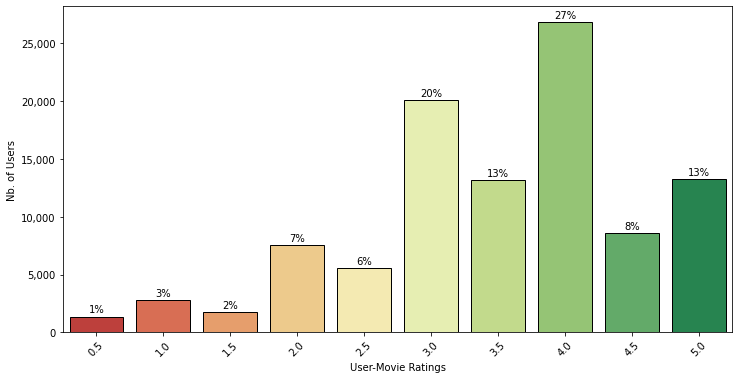

CPU times: user 251 ms, sys: 12.2 ms, total: 263 ms
Wall time: 2.13 s


In [166]:
%%time
movieRatingDistGroup = dfRatingsKdf['rating'].value_counts() \
                                             .sort_index() \
                                             .reset_index() \
                                             .to_pandas()

# Criando uma figura Matplotlib
fig, ax = plt.subplots(figsize=(12,6))

# Figura Principal: Seaborn Barplot
sns.barplot(data=movieRatingDistGroup, x='index', y='rating',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Configurando o eixo X e Y
ax.set_xlabel("User-Movie Ratings")
ax.set_ylabel('Nb. of Users')
ax.xaxis.set_tick_params(rotation=45)

# Separador no eixo y
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Adicionando o texto de porcentagem em cima de cada barra
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

# Visualizando o plot
plt.show()

## **Referências**

[Data Science: Primeiros passos](https://github.com/alura-cursos/introducao-a-data-science/)

[Designing a Scalable Movie Recommender System with Apache Spark and Google Colab](https://github.com/SJD1882/Big-Data-Recommender-Systems)

